<table>
    <tr>
        <td><img src="./img/Macc.png" width="auto"/></td>
        <td>
            <table><tr>
            <h1 style="color:blue;text-align:center">Lógica para Ciencias de la Computación</h1></td>
            </tr></table>   
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Entrega III: Visualización</p></tp>
            <tp><p style="font-size:150%;text-align:center">Grupo 06</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

In [1]:
"""
Librerías logica.py y solución de problemas. La visualización está en las sig. celdas
"""


from itertools import product
import numpy as np
from copy import deepcopy

class Formula :

    def __init__(self) :
        pass

    def __str__(self) :
        if type(self) == Letra:
            return self.letra
        elif type(self) == Negacion:
            return '-' + str(self.subf)
        elif type(self) == Binario:
            return "(" + str(self.left) + self.conectivo + str(self.right) + ")"

    def letras(self):
        if type(self) == Letra:
            return set(self.letra)
        elif type(self) == Negacion:
            return self.subf.letras()
        elif type(self) == Binario:
            return self.left.letras().union(self.right.letras())

    def subforms(self):
        if type(self) == Letra:
            return [str(self)]
        elif type(self) == Negacion:
            return list(set([str(self)] + self.subf.subforms()))
        elif type(self) == Binario:
            return list(set([str(self)] + self.left.subforms() + self.right.subforms()))

    def valor(self, I) :
        if type(self) == Letra:
            return I[self.letra]
        elif type(self) == Negacion:
            return not self.subf.valor(I)
        elif type(self) == Binario:
            if self.conectivo == 'Y':
                return self.left.valor(I) and self.right.valor(I)
            if self.conectivo == 'O':
                return self.left.valor(I) or self.right.valor(I)
            if self.conectivo == '>':
                return not self.left.valor(I) or self.right.valor(I)
            if self.conectivo == '=':
                return (self.left.valor(I) and self.right.valor(I)) or (not self.left.valor(I) and not self.right.valor(I))

    def SATtabla(self):
        letras = list(self.letras())
        n = len(letras)
        valores = list(product([True, False], repeat=n))
        for v in valores:
            I = {letras[x]: v[x] for x in range(n)}
            if self.valor(I):
                return I
        return None

    def clasifica_para_tableaux(self):
        if type(self) == Letra:
            return None, 'literal'
        elif type(self) == Negacion:
            if type(self.subf) == Letra:
                return None, 'literal'
            elif type(self.subf) == Negacion:
                return 1, 'alfa'
            elif type(self.subf) == Binario:
                if self.subf.conectivo == 'O':
                    return 3, 'alfa'
                elif self.subf.conectivo == '>':
                    return 4, 'alfa'
                elif self.subf.conectivo == 'Y':
                    return 1, 'beta'
        elif type(self) == Binario:
            if self.conectivo == 'Y':
                return 2, 'alfa'
            elif self.conectivo == 'O':
                return 2, 'beta'
            elif self.conectivo == '>':
                return 3, 'beta'

    def SATtableaux(self):
        estado = nodos_tableaux([self])
        res = estado.es_hoja()
        if res == 'cerrada':
            return None
        elif res == 'abierta':
            return estado.interp()
        frontera = [estado]
        while len(frontera) > 0:
            estado = frontera.pop(0)
            hijos = estado.expandir()
            for a in hijos:
                if a != None:
                    res = a.es_hoja()
                    if res == 'abierta':
                        return a.interp()
                    elif res == None:
                        frontera.append(a)
        return None

    def ver(self, D):
        '''
        Visualiza una fórmula A (como string en notación inorder) usando el descriptor D
        '''
        vis = []
        A = str(self)
        for c in A:
            if c == '-':
                vis.append(' no ')
            elif c in ['(', ')']:
                vis.append(c)
            elif c in ['>', 'Y', 'O']:
                vis.append(' ' + c + ' ')
            elif c == '=':
                vis.append(' sii ')
            else:
                try:
                    vis.append(D.escribir(c))
                except:
                    raise("¡Caracter inválido!")
        return ''.join(vis)

class Letra(Formula) :
    def __init__ (self, letra:str) :
        self.letra = letra

class Negacion(Formula) :
    def __init__(self, subf:Formula) :
        self.subf = subf

class Binario(Formula) :
    def __init__(self, conectivo:str, left:Formula, right:Formula) :
        assert(conectivo in ['Y','O','>','='])
        self.conectivo = conectivo
        self.left = left
        self.right = right

def inorder_to_tree(cadena:str):
    conectivos = ['Y', 'O', '>', '=']
    if len(cadena) == 1:
        return Letra(cadena)
    elif cadena[0] == '-':
        return Negacion(inorder_to_tree(cadena[1:]))
    elif cadena[0] == "(":
        counter = 0 #Contador de parentesis
        for i in range(1, len(cadena)):
            if cadena[i] == "(":
                counter += 1
            elif cadena[i] == ")":
                counter -=1
            elif cadena[i] in conectivos and counter == 0:
                return Binario(cadena[i], inorder_to_tree(cadena[1:i]),inorder_to_tree(cadena[i + 1:-1]))
    else:
        raise Exception('¡Cadena inválida!')

class Descriptor :

    '''
    Codifica un descriptor de N argumentos mediante un solo caracter
    Input:  args_lista, lista con el total de opciones para cada
                     argumento del descriptor
            chrInit, entero que determina el comienzo de la codificación chr()
    Output: str de longitud 1
    '''

    def __init__ (self,args_lista,chrInit=256) :
        self.args_lista = args_lista
        assert(len(args_lista) > 0), "Debe haber por lo menos un argumento"
        self.chrInit = chrInit
        self.rango = [chrInit, chrInit + np.prod(self.args_lista)]

    def check_lista_valores(self,lista_valores) :
        for i, v in enumerate(lista_valores) :
            assert(v >= 0), "Valores deben ser no negativos"
            assert(v < self.args_lista[i]), f"Valor debe ser menor o igual a {self.args_lista[i]}"

    def codifica(self,lista_valores) :
        self.check_lista_valores(lista_valores)
        cod = lista_valores[0]
        n_columnas = 1
        for i in range(0, len(lista_valores) - 1) :
            n_columnas = n_columnas * self.args_lista[i]
            cod = n_columnas * lista_valores[i+1] + cod
        return cod

    def decodifica(self,n) :
        decods = []
        if len(self.args_lista) > 1:
            for i in range(0, len(self.args_lista) - 1) :
                n_columnas = np.prod(self.args_lista[:-(i+1)])
                decods.insert(0, int(n / n_columnas))
                n = n % n_columnas
        decods.insert(0, n % self.args_lista[0])
        return decods

    def P(self,lista_valores) :
        codigo = self.codifica(lista_valores)
        return chr(self.chrInit+codigo)

    def inv(self,codigo) :
        n = ord(codigo)-self.chrInit
        return self.decodifica(n)

def Ytoria(lista_forms):
    form = ''
    inicial = True
    for f in lista_forms:
        if inicial:
            form = f
            inicial = False
        else:
            form = '(' + form + 'Y' + f + ')'
    return form

def Otoria(lista_forms):
    form = ''
    inicial = True
    for f in lista_forms:
        if inicial:
            form = f
            inicial = False
        else:
            form = '(' + form + 'O' + f + ')'
    return form

class nodos_tableaux:

    def __init__(self, fs):
        clasfs = [(A, str(A), *A.clasifica_para_tableaux()) for A in fs]
        self.alfas = [c for c in clasfs if c[3] == 'alfa']
        self.betas = [c for c in clasfs if c[3] == 'beta']
        self.literales = [c for c in clasfs if c[3] == 'literal']

    def __str__(self):
        cadena = f'Alfas:{[str(c[1]) for c in self.alfas]}\n'
        cadena += f'Betas:{[str(c[1]) for c in self.betas]}\n'
        cadena += f'Literales:{[str(c[1]) for c in self.literales]}'
        return cadena

    def tiene_lit_comp(self):
        lits = [c[1] for c in self.literales]
        l_pos = [l for l in lits if '-' not in l]
        l_negs = [l[1:] for l in lits if '-' in l]
        return len(set(l_pos).intersection(set(l_negs))) > 0

    def es_hoja(self):
        if self.tiene_lit_comp():
            return 'cerrada'
        elif ((len(self.alfas) == 0) and (len(self.betas) == 0)):
            return 'abierta'
        else:
            return None

    def interp(self):
        I = {}
        for lit in self.literales:
            l = lit[1]
            if '-' not in l:
                I[l] = True
            else:
                I[l[1:]] = False
        return I

    def expandir(self):
        '''Escoge última alfa, si no última beta, si no None'''
        f_alfas = deepcopy(self.alfas)
        f_betas = deepcopy(self.betas)
        f_literales = deepcopy(self.literales)
        if len(self.alfas) > 0:
            f, s, num_regla, cl = f_alfas.pop(0)
            if num_regla == 1:
                formulas = [f.subf.subf]
            elif num_regla == 2:
                formulas = [f.left, f.right]
            elif num_regla == 3:
                formulas = [Negacion(f.subf.left), Negacion(f.subf.right)]
            elif num_regla == 4:
                formulas = [f.subf.left, Negacion(f.subf.right)]
            for nueva_f in formulas:
                clasf = nueva_f.clasifica_para_tableaux()
                if clasf[1]== 'alfa':
                    lista = f_alfas
                elif clasf[1]== 'beta':
                    lista = f_betas
                elif clasf[1]== 'literal':
                    lista = f_literales
                strs = [c[1] for c in lista]
                if str(nueva_f) not in strs:
                    lista.append((nueva_f, str(nueva_f), *clasf))
            nuevo_nodo = nodos_tableaux([])
            nuevo_nodo.alfas = f_alfas
            nuevo_nodo.betas = f_betas
            nuevo_nodo.literales = f_literales
            return [nuevo_nodo, None]
        elif len(self.betas) > 0:
            f, s, num_regla, cl = f_betas.pop(0)
            if num_regla == 1:
                B1 = Negacion(f.subf.left)
                B2 = Negacion(f.subf.right)
            elif num_regla == 2:
                B1 = f.left
                B2 = f.right
            elif num_regla == 3:
                B1 = Negacion(f.left)
                B2 = f.right
            f_alfas2 = deepcopy(f_alfas)
            f_betas2 = deepcopy(f_betas)
            f_literales2 = deepcopy(f_literales)
            clasf = B1.clasifica_para_tableaux()
            if clasf[1]== 'alfa':
                lista = f_alfas
            elif clasf[1]== 'beta':
                lista = f_betas
            elif clasf[1]== 'literal':
                lista = f_literales
            strs = [c[1] for c in lista]
            if str(B1) not in strs:
                lista.append((B1, str(B1), *clasf))
            clasf = B2.clasifica_para_tableaux()
            if clasf[1]== 'alfa':
                lista = f_alfas2
            elif clasf[1]== 'beta':
                lista = f_betas2
            elif clasf[1]== 'literal':
                lista = f_literales2
            strs = [c[1] for c in lista]
            if str(B2) not in strs:
                lista.append((B2, str(B2), *clasf))
            n1 = nodos_tableaux([])
            n1.alfas = f_alfas
            n1.betas = f_betas
            n1.literales = f_literales
            n2 = nodos_tableaux([])
            n2.alfas = f_alfas2
            n2.betas = f_betas2
            n2.literales = f_literales2
            return [n1, n2]
        else:
            return [None, None]


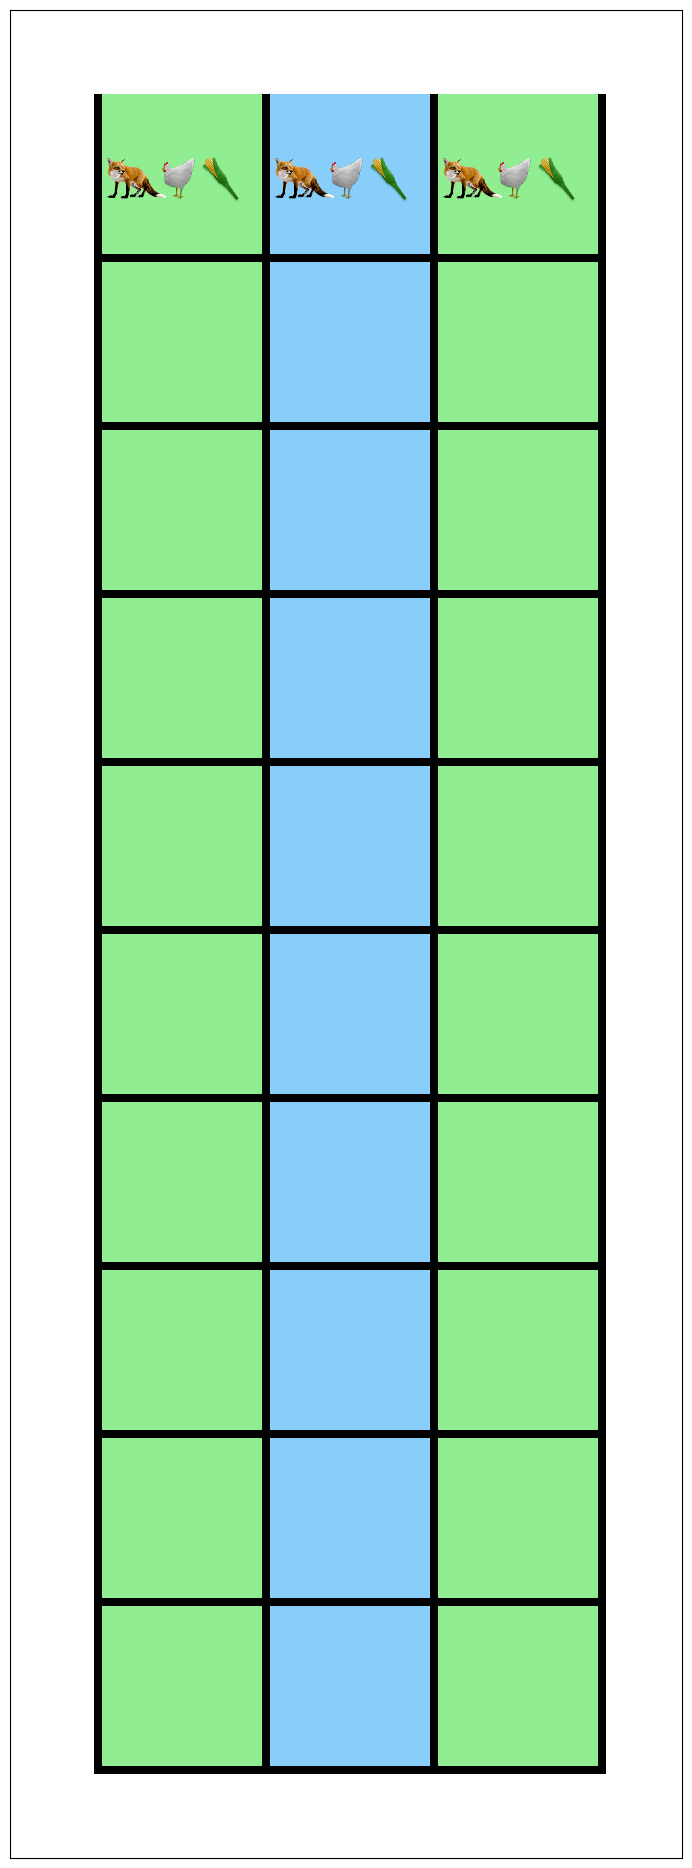

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from itertools import combinations
from types import MethodType

def escribir_caballos(self, literal): #Cambiaría para el nuestro, solo que no entiendo como
    if '-' in literal:
        atomo = literal[1:]
        neg = ' no'
    else:
        atomo = literal
        neg = ''
    x, y  = self.inv(atomo)
    return f"El caballo{neg} está en la casilla ({x},{y})"

def escribir_rejilla(self, literal): # Tal vez este se parezca mejor al nuestro
    if '-' in literal:
        atomo = literal[1:]
        neg = ' no'
    else:
        atomo = literal
        neg = ''
    n, x, y  = self.inv(atomo)
    return f"El número {n}{neg} está en la casilla ({x},{y})"

class Cruce:

    def __init__(self):
        self.CenC = Descriptor([3, 10])
        self.CenC.escribir = MethodType(escribir_rejilla, self.CenC)

    def visualizar(self, I):
        fig, axes = plt.subplots(figsize=(48,24))
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)

        step = 1. / 10
        tangulos = []
        direcciones = {}

        for i in range(3):
            for j in range(10):
                color = 'lightgreen' if i == 0 or i == 2 else 'lightskyblue'
                tangulos.append(patches.Rectangle(*[(i * step, j * step), step, step], facecolor=color))
                direcciones[(i, j)] = [i * step + step / 2, 1 - j * step - step / 2]

        for i in range(10):
            locacion = i * step
            tangulos.append(patches.Rectangle(*[(0, locacion), 3 * step, 0.005], facecolor='black'))
            tangulos.append(patches.Rectangle(*[(i * step, 0), 0.005, 1], facecolor='black'))

        for t in tangulos:
            axes.add_patch(t)

        arr_gallina = plt.imread("./img/gallina.png", format='png')
        arr_fox = plt.imread("./img/zorro.png", format='png')
        arr_corn = plt.imread("./img/maiz.png", format='png')

        imagebox_gallina = OffsetImage(arr_gallina, zoom=0.3)
        imagebox_fox = OffsetImage(arr_fox, zoom=0.3)
        imagebox_corn = OffsetImage(arr_corn, zoom=0.3)

        imagebox_gallina.image.axes = axes
        imagebox_fox.image.axes = axes
        imagebox_corn.image.axes = axes

        for l in I:
            if I[l]:
                x, y = self.CenC.inv(l)
                ab_gallina = AnnotationBbox(imagebox_gallina, direcciones[(x, y)], frameon=False)
                axes.add_artist(ab_gallina)

                ab_fox = AnnotationBbox(imagebox_fox, [direcciones[(x, y)][0] - step / 4, direcciones[(x, y)][1]], frameon=False)
                axes.add_artist(ab_fox)

                ab_corn = AnnotationBbox(imagebox_corn, [direcciones[(x, y)][0] + step / 4, direcciones[(x, y)][1]], frameon=False)
                axes.add_artist(ab_corn)

        axes.set_xlim(-step / 2, 3 * step + step / 2)
        axes.set_ylim(-step / 2, 1 + step / 2)
        axes.set_aspect('equal', 'box')  # Maintain aspect ratio
    
        plt.show()

c = Cruce()
I = {c.CenC.P([0,0]): True, c.CenC.P([1,0]): True, c.CenC.P([2,0]): True}
c.visualizar(I)